<a href="https://colab.research.google.com/github/project-ida/cr39/blob/main/notebooks/CR39_analysis_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# CR39 track Analysis

The analysis notebook contains starter code for doing CR39 track analysis.




## Libraries

In [ ]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth

# Data analysis
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Authentication

We need to authenticate in order to bring in the database credentials from Google drive so that we can pull data from the live database.

In [ ]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials.py", "psql_credentials.py")

Mounted at /content/drive


'psql_credentials.py'

In [ ]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

## Getting track data for a specific experiment

In [ ]:
id = "test-01"

In [ ]:
df_tracks = pd.read_sql(f"""
    SELECT tile_position, track_position, features
    FROM cr39_tracks where experiment_id='{id}'
""", engine)

In [ ]:
df_tracks.head()

,tile_position,track_position,features
0,"[1, 0]","[47.5, 322.5]","[8.4275, 13.3094]"
1,"[1, 0]","[191.5, 303.0]","[25.7446, 27.408]"
2,"[1, 0]","[209.0, 244.0]","[5.0662, 5.5937]"
3,"[1, 0]","[134.5, 130.0]","[24.195, 27.2571]"
4,"[1, 0]","[30.5, 125.5]","[21.5834, 24.1534]"


The `tile_position` are the [x,y] coordinates of the image tile.

The `track_positions` are the [x,y] coordiantes of the track relative to the specific image tile.

The `features` are [minor, major] axes that describe the elipctical fit to the track in question.

## Track statistics

We can aggregate the track features in various ways. With SQL, we can easily perform aggegations across all experiments. The simplest is to see how many total tracks we have.

In [ ]:
df_count = pd.read_sql(f"""
  SELECT COUNT(*) FROM cr39_tracks
""", engine)

In [ ]:
df_count

,count
0,28


We can get a sense of the average track density by measuring the average number of tracks per tile.

In [ ]:
df_density = pd.read_sql(f"""
    SELECT
    ROUND(COUNT(*)::numeric / COUNT(DISTINCT tile_position), 2) AS avg_tracks_per_tile
    FROM cr39_tracks;

""", engine)

In [ ]:
df_density

,avg_tracks_per_tile
0,7.0



We can also get a sense of the common size of track by calculating the size of the elipse and making a histogram.

In [ ]:
df_area_hist = pd.read_sql(f"""
  SELECT
      width_bucket(area, 0, 5000, 20) AS bucket,
      MIN(area) AS bin_start,
      MAX(area) AS bin_end,
      COUNT(*) AS track_count
  FROM (
      SELECT (PI() * (features[1] / 2.0) * (features[2] / 2.0))::numeric AS area
      FROM cr39_tracks
  ) sub
  GROUP BY bucket
  ORDER BY bucket;
""", engine)


In [ ]:
df_area_hist.tail()

,bucket,bin_start,bin_end,track_count
5,6,1300.215157,1300.215157,1
6,7,1644.507499,1673.048554,2
7,11,2697.782851,2697.782851,1
8,12,2833.977505,2833.977505,1
9,13,3204.852373,3204.852373,1


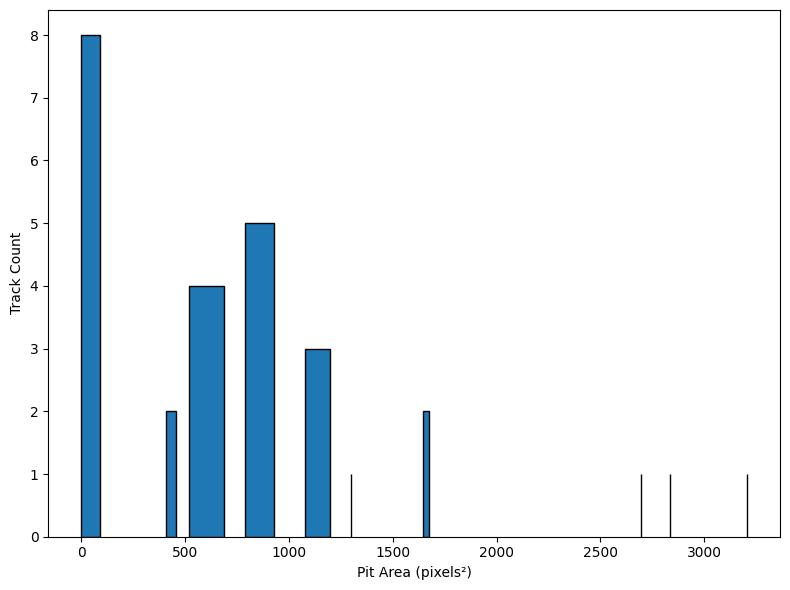

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(df_area_hist["bin_start"], df_area_hist["track_count"],
        width=df_area_hist["bin_end"] - df_area_hist["bin_start"],
        align='edge', edgecolor='black')

plt.xlabel("Pit Area (pixels²)")
plt.ylabel("Track Count")
plt.tight_layout()
plt.show()